# CNN

### References:
1. https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import time
import zipfile
import lzma
import pickle
from PIL import Image
from shutil import copy2
import gc

import cv2

### Run name

In [3]:
project_name = 'SC_Iceberg_Classifier'
step_name = 'CNN_3channel_Inception'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: SC_Iceberg_Classifier_CNN_3channel_Inception_20180107_213105


### Basic folders

In [4]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)

input_path: D:\Kaggle\digit-recognizer\input
log_path: D:\Kaggle\digit-recognizer\log
model_path: D:\Kaggle\digit-recognizer\model
output_path: D:\Kaggle\digit-recognizer\output


### Basic functions

In [5]:
import sys
def describe(arr):
    print(arr.shape, arr.min(), arr.max(), sys.getsizeof(arr))

In [6]:
def show_data_images(rows, fig_column, y_data, *args):
    columns = len(args)
    figs, axes = plt.subplots(rows, columns, figsize=(rows, fig_column*columns))
    print(axes.shape)  
    for i, ax in enumerate(axes):
        y_data_str = ''
        if type(y_data) != type(None):
            y_data_str =  '_' + str(y_data[i])
        ax[0].set_title('28x28' + y_data_str)
        for j, arg in enumerate(args):
            ax[j].imshow(arg[i])

### Load data

In [7]:
train_file = os.path.join(input_path, 'train.csv')
test_file = os.path.join(input_path, 'test.csv')

In [8]:
%%time
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')
x_data = raw_data[:,1:]
y_data = raw_data[:,0]

x_test = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')

describe(x_data)
describe(y_data)
describe(x_test)

(42000, 784) 0 255 112
(42000,) 0 9 96
(28000, 784) 0 255 112
Wall time: 43.1 s


In [9]:
x_data = x_data/255.
x_data = x_data/255.

describe(x_data)
describe(x_test)

x_data = x_data.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

describe(x_data)
describe(x_test)

(42000, 784) 0.0 0.00392156862745 263424112
(28000, 784) 0 255 112
(42000, 28, 28, 1) 0.0 0.00392156862745 144
(28000, 28, 28, 1) 0 255 144


Text(0.5,1,'28x28 data')

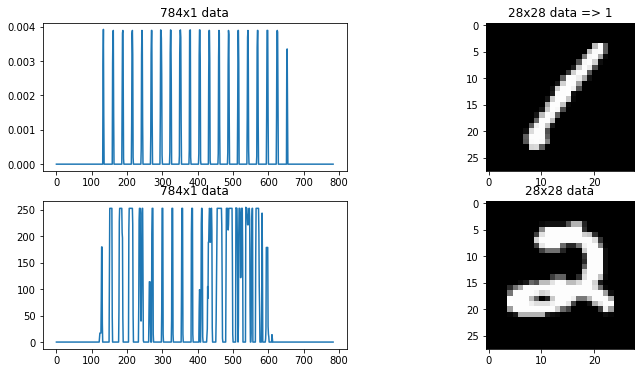

In [10]:
index = 0
fig, ax = plt.subplots(2, 2, figsize=(12,6))
ax[0, 0].plot(x_data[index].reshape(784,))
ax[0, 0].set_title('784x1 data')
ax[0, 1].imshow(x_data[index].reshape(28,28), cmap='gray')
ax[0, 1].set_title('28x28 data => ' + str(y_data[index]))
                 
ax[1, 0].plot(x_test[index].reshape(784,))
ax[1, 0].set_title('784x1 data')
ax[1, 1].imshow(x_test[index].reshape(28,28), cmap='gray')
ax[1, 1].set_title('28x28 data')

In [11]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
print(y_data[0])
y_data = to_categorical(y_data)
#example:
print(y_data[0])

Using TensorFlow backend.


1
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.05, random_state=31)
describe(x_train)
describe(x_val)
describe(y_train)
describe(y_val)

(39900, 28, 28, 1) 0.0 0.00392156862745 250252944
(2100, 28, 28, 1) 0.0 0.00392156862745 13171344
(39900, 10) 0.0 1.0 3192112
(2100, 10) 0.0 1.0 168112


### Build model

In [13]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalMaxPooling2D
from keras.layers.merge import Concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

In [14]:
def build_model():
    bn_model = 0
    p_activation = "relu"
    input_1 = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), name="input")
    
    img_1 = Conv2D(32, kernel_size = (1,1), activation=p_activation, padding='same')(input_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.4)(img_1)
    
    img_2 = Conv2D(32, kernel_size = (2,2), activation=p_activation, padding='same')(input_1)
    img_2 = BatchNormalization()(img_2)
    img_2 = MaxPooling2D((2,2)) (img_2)
    img_2 = Dropout(0.4)(img_2)
    
    img_3 = Conv2D(32, kernel_size = (3,3), activation=p_activation, padding='same')(input_1)
    img_3 = BatchNormalization()(img_3)
    img_3 = MaxPooling2D((2,2)) (img_3)
    img_3 = Dropout(0.4)(img_3)
    
    img_5 = Conv2D(32, kernel_size = (5,5), activation=p_activation, padding='same')(input_1)
    img_5 = BatchNormalization()(img_5)
    img_5 = MaxPooling2D((2,2)) (img_5)
    img_5 = Dropout(0.4)(img_5)
    
    concat_layer = (Concatenate()([img_1, img_2, img_3, img_5]))
#############################################################################################
    img_1 = Conv2D(32, kernel_size = (1,1), activation=p_activation, padding='same')(concat_layer)
    img_1 = BatchNormalization()(img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.4)(img_1)
    
    img_2 = Conv2D(32, kernel_size = (2,2), activation=p_activation, padding='same')(concat_layer)
    img_2 = BatchNormalization()(img_2)
    img_2 = MaxPooling2D((2,2)) (img_2)
    img_2 = Dropout(0.4)(img_2)
    
    img_3 = Conv2D(32, kernel_size = (3,3), activation=p_activation, padding='same')(concat_layer)
    img_3 = BatchNormalization()(img_3)
    img_3 = MaxPooling2D((2,2)) (img_3)
    img_3 = Dropout(0.4)(img_3)
    
    img_5 = Conv2D(32, kernel_size = (5,5), activation=p_activation, padding='same')(concat_layer)
    img_5 = BatchNormalization()(img_5)
    img_5 = MaxPooling2D((2,2)) (img_5)
    img_5 = Dropout(0.4)(img_5)
    
    concat_layer = (Concatenate()([img_1, img_2, img_3, img_5]))
#############################################################################################
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same')(concat_layer)
    img_1 = BatchNormalization()(img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.4)(img_1)
#############################################################################################
    img_1 = Conv2D(128, kernel_size = (3,3), activation=p_activation, padding='same')(img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.4)(img_1)
#############################################################################################

    img_1 = GlobalMaxPooling2D() (img_1)

    dense_ayer = Dense(1024, activation=p_activation)(img_1)
#     dense_ayer = BatchNormalization()(dense_ayer)
    dense_ayer = Dropout(0.4)(dense_ayer)
    dense_ayer = Dense(1024, activation=p_activation)(dense_ayer)
    dense_ayer = Dropout(0.4)(dense_ayer)
    dense_ayer = Dense(128, activation=p_activation)(dense_ayer)
    dense_ayer = Dropout(0.4)(dense_ayer)
    output = Dense(10, activation='softmax')(dense_ayer)

    model = Model(input_1, output)
    
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])
    return model

In [15]:
model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   64          input[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   160         input[0][0]                      
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 32)   320         input[0][0]                      
__________________________________________________________________________________________________
conv2d_4 (

In [16]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
# saveModel(model, 'saveModel_test')

In [17]:
def get_lr(x):
    lr = round(1e-4 * 0.995 ** x, 6)
    if lr < 5e-5:
        lr = 5e-5
    print(lr, end='  ')
    return lr

# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
annealer = LearningRateScheduler(get_lr)

log_dir = os.path.join(log_path, run_name)
print('log_dir:' + log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)

log_dir:D:\Kaggle\digit-recognizer\log\SC_Iceberg_Classifier_CNN_3channel_Inception_20180107_213105


In [18]:
datagen = ImageDataGenerator(
    zoom_range = 0.2,
    rotation_range = 20,
    height_shift_range = 0.2,
    width_shift_range = 0.2
)

In [19]:
%%time
hist = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=64, seed=2017),
    steps_per_epoch=100,
    epochs=100, #Increase this when not on Kaggle kernel
    verbose=1,  #1 for ETA, 0 for silent
    callbacks=[annealer],
    max_queue_size= 64,
    workers= 16,
    validation_data=(x_val[:400,:], y_val[:400,:])
)

0.0001  Epoch 1/100
100/100 [==============================] - 30s 303ms/step - loss: 2.4808 - acc: 0.0988 - val_loss: 2.2961 - val_acc: 0.1400
0.0001  Epoch 2/100
100/100 [==============================] - 28s 277ms/step - loss: 2.3275 - acc: 0.1133 - val_loss: 2.2950 - val_acc: 0.1400
9.9e-05  Epoch 3/100
100/100 [==============================] - 28s 280ms/step - loss: 2.3097 - acc: 0.1204 - val_loss: 2.3028 - val_acc: 0.1400
9.9e-05  Epoch 4/100
100/100 [==============================] - 28s 278ms/step - loss: 2.2847 - acc: 0.1425 - val_loss: 2.4539 - val_acc: 0.1400
9.8e-05  Epoch 5/100
100/100 [==============================] - 28s 279ms/step - loss: 2.2422 - acc: 0.1689 - val_loss: 2.9670 - val_acc: 0.1400
9.8e-05  Epoch 6/100
100/100 [==============================] - 28s 276ms/step - loss: 2.1831 - acc: 0.1864 - val_loss: 3.3323 - val_acc: 0.1400
9.7e-05  Epoch 7/100
100/100 [==============================] - 28s 278ms/step - loss: 2.1364 - acc: 0.2020 - val_loss: 2.9779 - val

100/100 [==============================] - 28s 284ms/step - loss: 0.4844 - acc: 0.8574 - val_loss: 0.2299 - val_acc: 0.9450
7.5e-05  Epoch 58/100
100/100 [==============================] - 28s 278ms/step - loss: 0.4840 - acc: 0.8509 - val_loss: 0.1537 - val_acc: 0.9575
7.5e-05  Epoch 59/100
100/100 [==============================] - 28s 282ms/step - loss: 0.4722 - acc: 0.8572 - val_loss: 0.1847 - val_acc: 0.9525
7.4e-05  Epoch 60/100
100/100 [==============================] - 28s 282ms/step - loss: 0.4476 - acc: 0.8653 - val_loss: 0.1291 - val_acc: 0.9600
7.4e-05  Epoch 61/100
100/100 [==============================] - 28s 278ms/step - loss: 0.4674 - acc: 0.8559 - val_loss: 0.2660 - val_acc: 0.9175
7.4e-05  Epoch 62/100
100/100 [==============================] - 28s 279ms/step - loss: 0.4596 - acc: 0.8583 - val_loss: 0.1264 - val_acc: 0.9650
7.3e-05  Epoch 63/100
100/100 [==============================] - 29s 292ms/step - loss: 0.4338 - acc: 0.8702 - val_loss: 0.1281 - val_acc: 0.9550


In [20]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.1669, final accuracy: 0.9457


In [21]:
final_acc_str = '{0:0>4}'.format(int(final_acc*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name_acc)

SC_Iceberg_Classifier_CNN_3channel_Inception_20180107_213105_9457


In [22]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


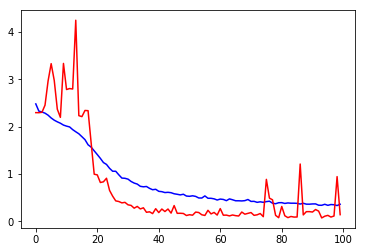

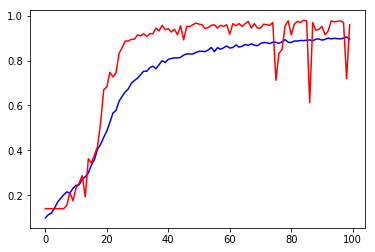

In [23]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [24]:
saveModel(model, run_name_acc)

In [25]:
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[210   0   0   0   0   0   4   0   0   0]
 [  0 236   0   0   6   0   5   1   0   0]
 [  0   0 203   0   0   0   1   1  16   0]
 [  1   0   0 169   0   0   0   4  12   1]
 [  0   0   0   0 222   0   3   0   0   4]
 [  0   0   0   2   1 165   8   0  16   5]
 [  0   0   0   0   0   0 197   0   0   0]
 [  0   0   1   0   1   0   0 179   1   6]
 [  0   0   0   0   0   0   2   0 208   1]
 [  0   0   0   2   4   0   0   0   5 197]]


## Predict

In [26]:
if not os.path.exists(output_path):
    os.mkdir(output_path)
pred_file = os.path.join(output_path, run_name_acc + '.csv')
print(pred_file)

D:\Kaggle\digit-recognizer\output\SC_Iceberg_Classifier_CNN_3channel_Inception_20180107_213105_9457.csv


In [27]:
y_hat = model.predict(x_test, batch_size=64)

In [28]:
y_pred = np.argmax(y_hat,axis=1)

In [29]:
with open(pred_file, 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))

In [30]:
t1 = time.time()
print('time cost: %.2f s' % (t1-t0))
print('Done!')

time cost: 2919.74 s
Done!


In [31]:
print(run_name_acc)

SC_Iceberg_Classifier_CNN_3channel_Inception_20180107_213105_9457
